Common Task 1. Auto-encoder of the quark/gluon events

Please train a variational auto-encoder to learn the representation based on three image channels (ECAL, HCAL and Tracks) for the dataset. 

 Please show a side-by-side comparison of original and reconstructed events. 


# Importing Dependencies

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras.callbacks import EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing Data and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data from HDF5 file
data_path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5"  # Replace with your own file path

with h5py.File(data_path, 'r') as f:
    print(f"Keys: {list(f.keys())}")
    X_jets = f['X_jets'][0:8000]                   #To work with only a subset of all images due to computational limit
    print(f"X_jets shape: {X_jets.shape}")         # Consists of image data
    # m0 = f["m0"]
    # pt = f["pt"]
    # y = f["y"]
    # print(f"m0 shape: {m0.shape}")               # Mass 
    # print(f"pt shape: {pt.shape}")               # Transverse momentum 
    # print(f"y shape: {y.shape}")                 # Labels 

# print(X_jets.shape)

Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (8000, 125, 125, 3)


In [ ]:
# Resizing images from (125, 125, 3) to (128, 128, 3) as when decoding we want image to be in power of 2's dimension for ConvTranspose to retrieve original image dimensions
X_jets_resized = np.zeros((X_jets.shape[0], 128, 128, 3))
for i in range(X_jets.shape[0]):
    X_jets_resized[i] = smart_resize(X_jets[i], (128, 128))

X_jets = X_jets_resized
del(X_jets_resized)

In [ ]:
# Normalize the input images to have values between 0 and 1 using min-max scaling.
print("Previous min, max and mean :-")
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

X_jets = (X_jets - X_jets.min()) / (X_jets.max() - X_jets.min()) 

print("\nAfter normalization min, max and mean :-")
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

Previous min, max and mean :-
0.0
3.6701583862304688
5.29798520288415e-05

After normalization min, max and mean :-
0.0
1.0
1.4435303998761709e-05


# Data Visualization

In [ ]:
# Normalize Track, ECAL, HCAL data using mean and standard deviation
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal


combined = normalized_track + normalized_ecal + normalized_hcal
combined = np.expand_dims(combined, axis=-1)  # Reshape to (n, 128, 128, 1)

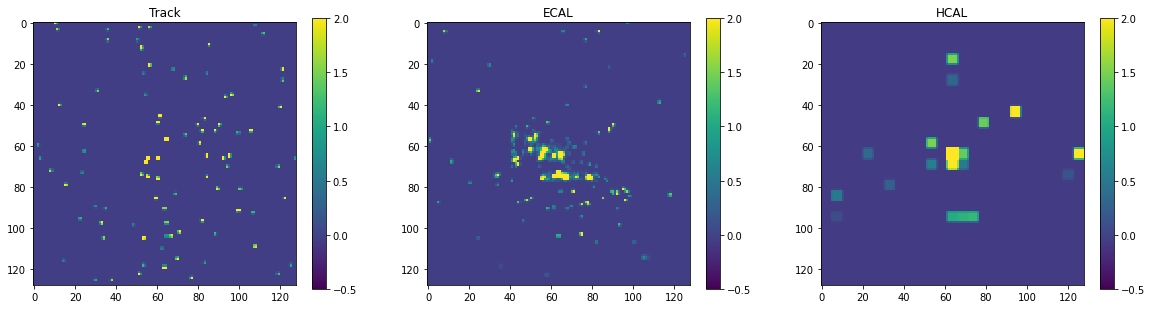

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(normalized_track[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(normalized_ecal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(normalized_hcal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

# Add colorbars
fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

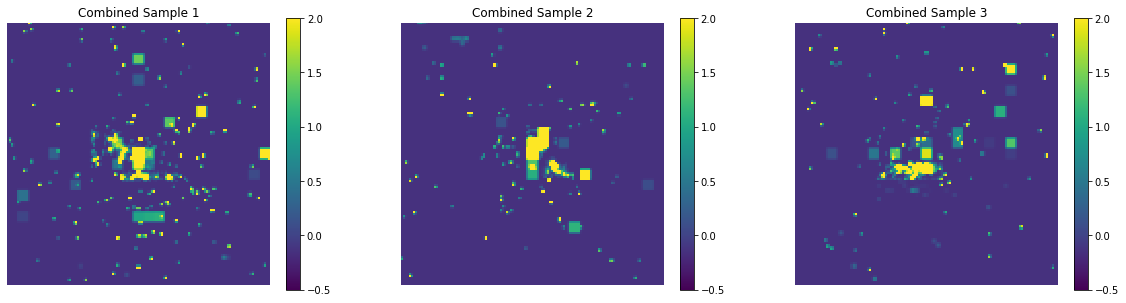

In [ ]:
# Select number of images to display
num_images = 3

# Display original images from X_jets
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(3):
    temp = axes[i].imshow(combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('Combined Sample {}'.format(i+1))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)
        

In [ ]:
del(mean_track)
del(std_track)
del(normalized_track)
del(mean_ecal)
del(std_ecal)
del(normalized_ecal)
del(mean_hcal)
del(std_hcal)
del(normalized_hcal)
del(combined)

# Building and Training the Model

In [ ]:
train_datagen = ImageDataGenerator(
        validation_split=0.2 # split 20% of data for validation set
)

train_generator = train_datagen.flow(
        x=X_jets,
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='training' # use subset 'training' to generate training data
)

valid_generator = train_datagen.flow(
        x=X_jets,
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='validation' # use subset 'validation' to generate validation data
)

In [ ]:
def vae_loss(encoder_inputs, outputs, z_mean, z_log_var):
    # reconstruction_loss = keras.losses.mae(encoder_inputs, outputs)                        # Mean Absolute Error
    # reconstruction_loss = keras.losses.mse(encoder_inputs, outputs)                      # Mean Squared Error
    reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)      # Binary Cross Entropy
    reconstruction_loss *= 128 * 128 * 3
    # reconstruction_loss *= 125 * 125 * 3                                      #Use this for reconstruction loss if image not resized to 128, 128, 3
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    return reconstruction_loss + kl_loss
    
# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define VAE architecture
latent_dim = 1024

# Define encoder model
encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


# Define decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(encoder.summary())
print(decoder.summary())

# Define VAE model
outputs = decoder([sampling([z_mean, z_log_var])])

vae = keras.Model(encoder_inputs, outputs, name="vae")

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2d_1[0][0]']         

In [ ]:
# Compile VAE model
vae.add_loss(vae_loss(encoder_inputs, outputs, z_mean, z_log_var))
# vae.compile(optimizer="adam")

optimizer = keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

# Train VAE model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = vae.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=20,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // valid_generator.batch_size,
        callbacks=[es],
        verbose=1
)

Epoch 1/20
200/200 [==============================] - 489s 2s/step - loss: 1192.9639 - val_loss: 16.6147
Epoch 2/20
200/200 [==============================] - 535s 3s/step - loss: 13.5043 - val_loss: 11.4129
Epoch 3/20
200/200 [==============================] - 490s 2s/step - loss: 10.1845 - val_loss: 9.4007
Epoch 4/20
200/200 [==============================] - 486s 2s/step - loss: 8.9194 - val_loss: 8.6687
Epoch 5/20
200/200 [==============================] - 485s 2s/step - loss: 8.4881 - val_loss: 8.2965
Epoch 6/20
200/200 [==============================] - 490s 2s/step - loss: 8.1443 - val_loss: 8.0783
Epoch 7/20
200/200 [==============================] - 489s 2s/step - loss: 7.9859 - val_loss: 8.0215
Epoch 8/20
200/200 [==============================] - 489s 2s/step - loss: 7.8701 - val_loss: 7.8638
Epoch 9/20
200/200 [==============================] - 490s 2s/step - loss: 7.7937 - val_loss: 7.8012
Epoch 10/20
200/200 [==============================] - 490s 2s/step - loss: 7.7383 -

1/1 [==============================] - 0s 150ms/step
(8000, 128, 128)
(128, 128)
(3, 128, 128)
(128, 128)


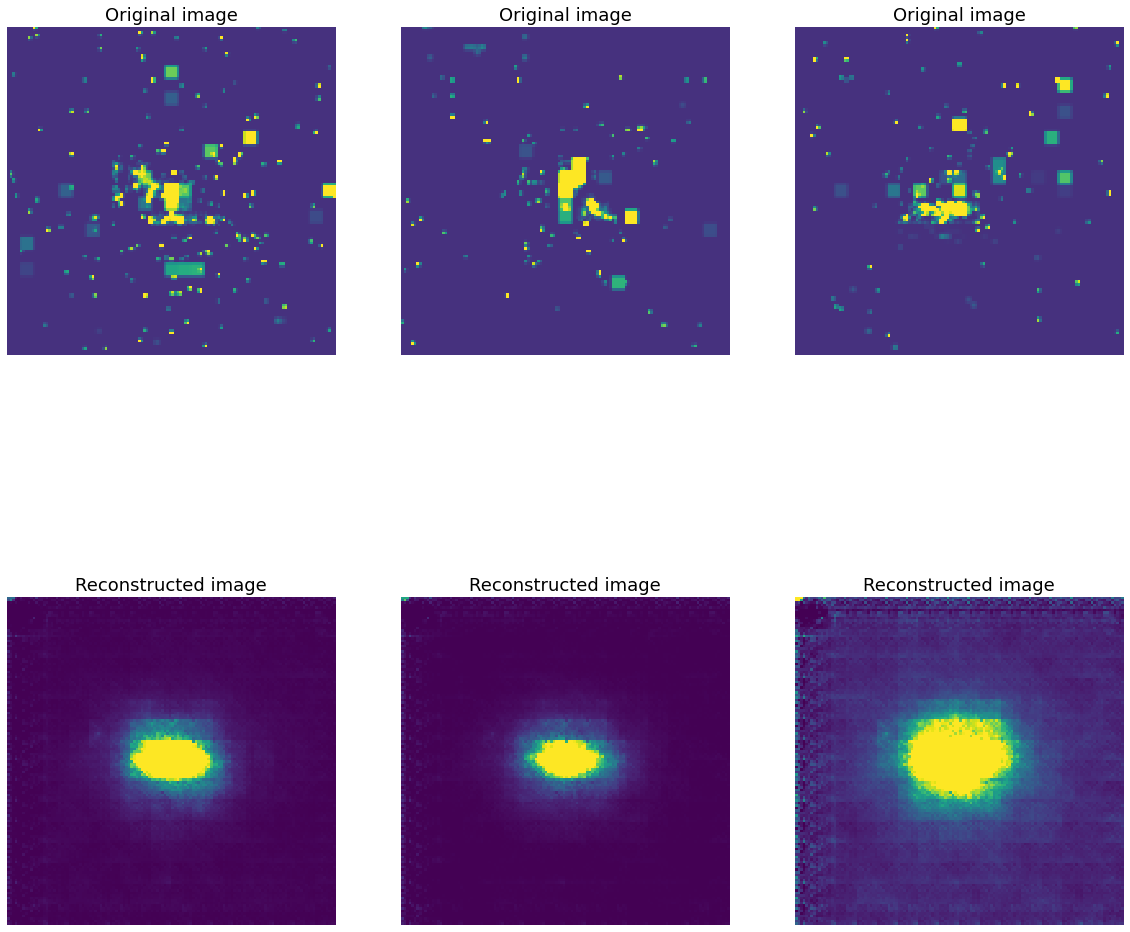

In [ ]:
# Select some random samples from the dataset
samples = X_jets[:3]

# Encode the samples using the VAE's encoder
z_mean, z_log_var = encoder.predict(samples)
batch_size = 3

# Decode the encoded samples using the VAE's decoder
reconstructed_samples = decoder.predict(z_mean + np.exp(0.5 * z_log_var) * np.random.normal(size=(batch_size, latent_dim)))

# print(type(reconstructed_samples))
# print(reconstructed_samples.shape)
# print(np.unique(reconstructed_samples))
# # print(reconstructed_samples)

mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal

X_jets_combined = normalized_track + normalized_ecal + normalized_hcal
# X_jets_combined = X_jets[:,:,:,0] + X_jets[:,:,:,1] + X_jets[:,:,:,2]
print(X_jets_combined.shape)
print(X_jets_combined[0].shape)

###############
X_jets_combined = np.expand_dims(X_jets_combined, axis=-1)  # Reshape to (n, 125, 125, 1)

mean_track = np.mean(reconstructed_samples[:,:,:,0])
std_track = np.std(reconstructed_samples[:,:,:,0])
normalized_track = (reconstructed_samples[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(reconstructed_samples[:,:,:,1])
std_ecal = np.std(reconstructed_samples[:,:,:,1])
normalized_ecal = (reconstructed_samples[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(reconstructed_samples[:,:,:,2])
std_hcal = np.std(reconstructed_samples[:,:,:,2])
normalized_hcal = (reconstructed_samples[:,:,:,2] - mean_hcal) / std_hcal

reconstructed_samples = normalized_track + normalized_ecal + normalized_hcal

print(reconstructed_samples.shape)
print(reconstructed_samples[0].shape)

###############
reconstructed_samples = np.expand_dims(reconstructed_samples, axis=-1)  # Reshape to (n, 125, 125, 1)

del(mean_track)
del(std_track)
del(normalized_track)
del(mean_ecal)
del(std_ecal)
del(normalized_ecal)
del(mean_hcal)
del(std_hcal)
del(normalized_hcal)

# Display some of the original images and reconstructed samples
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i in range(3):
    axes[0, i].imshow(X_jets_combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original image', fontsize=18)  # Add label to the subplot

for i in range(3):
    axes[1, i].imshow(reconstructed_samples[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed image', fontsize=18)  # Add label to the subplot

fig.subplots_adjust(hspace=0.1)
# plt.tight_layout()  # Reduce whitespace between subplots
plt.show()


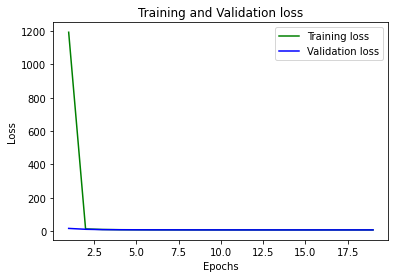

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1, len(loss_train) + 1)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

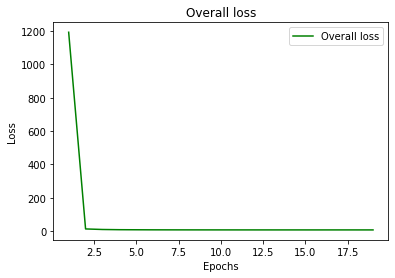

In [ ]:
# Plot the overall loss
loss_train = history.history['loss']
epochs = range(1, len(loss_train) + 1)

plt.plot(epochs, loss_train, 'g', label='Overall loss')
plt.title('Overall loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


100/100 [==============================] - 19s 193ms/step


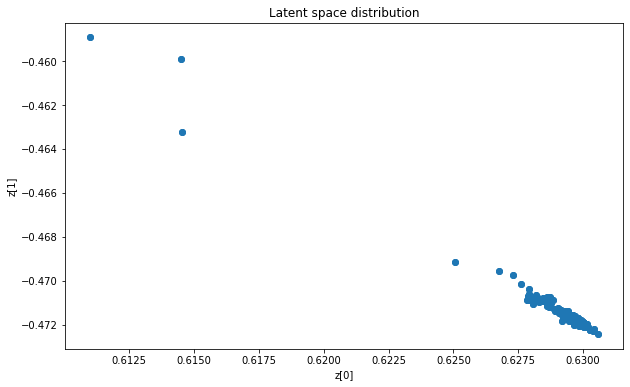

In [ ]:
# Plot the distribution of the latent space
num_samples = 100
test_images = []
for i in range(num_samples):
    x = next(valid_generator)
    test_images.append(x)

x_test = np.array(test_images)
# Reshape the test images array
x_test = x_test.reshape((-1, 128, 128, 3))
# x_test = x_test.reshape((-1, 125, 125, 3))

z_mean, z_log_var = encoder.predict(x_test)

plt.figure(figsize=(10, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent space distribution")
plt.show()

In [ ]:
print(X_jets_combined.shape)
print(X_jets_combined[0].shape)
print(reconstructed_samples.shape)
print(reconstructed_samples[0].shape)

(8000, 128, 128, 1)
(128, 128, 1)
(3, 128, 128, 1)
(128, 128, 1)


# Discussion




*  Plot of training and validation loss suggests that validation losses for every epoch seem to be stuck around a value, indicating that the model is not improving much. Possible reasons can be:-
    *   Model architecture not being complex enough to capture the underlying patterns in the data, 
    *   Only a subset of dataset was used for training(~8000 images) 
    *   Data being too noisy and not providing clear patterns for the model to learn.
*   Data augmentation techniques like random blur, random crop, random rotation did not seem suitable as we are not working with classical images but with raw physical data.

*   Distribution of latent space plot shows only a few dots far away from the rest of the dots that are clustered in one place. This suggests that the model is unable to differentiate between the two classes of images, quark and gluon, and is instead producing a single cluster of images.


# Other architectures tried out


### In this architecture the encoder uses a pretrained ResNet50 archietcture to learn the image features. For this, loss and val_loss were lower but reconstructed images were simply blank or few dots spread across the border possibly because we are not working with classical images with RGB channel

In [ ]:

# Define VAE architecture
latent_dim = 512

# Encoder
encoder_inputs = keras.Input(shape=(125, 125, 3))

x = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights=None, input_shape=(125, 125, 3))(encoder_inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
x = keras.layers.Reshape((16, 16, 256))(x)
x = keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu")(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu")(x)
decoder_outputs = keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="sigmoid")(x)

# print(decoder_outputs.shape.as_list())  # Gives (128, 128, 3) so I want to resize it to (125, 125, 3)
decoder_outputs = tf.image.resize(decoder_outputs, (125, 125), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Use tf.image.resize to resize the output to match the input shape of the encoder model

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(encoder.summary())
print(decoder.summary())

# Define VAE model
outputs = decoder([sampling([z_mean, z_log_var])])

vae = keras.Model(encoder_inputs, outputs, name="vae")

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2 (Functional)        (None, 4, 4, 2048)   23564800    ['input_4[0][0]']                
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['resnet50v2[0][0]']             
 obalAveragePooling2D)                                                                            
                                                                                            

### In this architecture image is flattened and dense layers are used instead on convolutional layers

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.models import Model

input_shape = (128, 128, 3)
input_dim = input_shape[0] * input_shape[1] * input_shape[2]

# Define the encoder architecture
encoder_input = Input(shape=(input_dim,))
x = Dense(512, activation='relu')(encoder_input)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
encoder_output = Dense(64, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Define the decoder architecture
x = Dense(128, activation='relu')(encoder_output)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(input_dim, activation='sigmoid')(x)
decoder_output = Reshape(input_shape)(x)

# Combine the encoder and decoder into a single model
vae = Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model
vae.compile(optimizer='adam', loss='mse')

### In this architecture instead of resizing input images to multiple of 2's i.e (128, 128, 3), the decoder output is resized to match input image (125, 125, 3)

In [ ]:
#In this architecture instead of resizing input images to multiple of 2's i.e (128, 128, 3), the decoder output is resized to match input image (125, 125, 3)

# Define VAE architecture
latent_dim = 512

# Define encoder model
encoder_inputs = keras.Input(shape=(125, 125, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


# Define decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(latent_inputs)
x = layers.Dense(16 * 16 * 64, activation="relu")(x)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)

print(decoder_outputs.shape.as_list())  # Gives (128, 128, 3) so I want to resize it to (125, 125, 3)
decoder_outputs = tf.image.resize(decoder_outputs, (125, 125), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Use tf.image.resize to resize the output to match the input shape of the encoder model

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(encoder.summary())
print(decoder.summary())

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())


[None, 128, 128, 3]
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2

### In this architecture max pooling and upsampling were used but reconstructed images were very blurry and blob-like

In [ ]:
latent_dim = 1024

# Define encoder model
encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(64, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Define decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16*16*16)(latent_inputs)
x = layers.Reshape((16, 16, 16))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2,2))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2,2))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(size=(2,2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


print(encoder.summary())
print(decoder.summary())

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())

### In this architecture batch normalization is used but it only slowered the training process and no significant impact on reconstructed images quality

In [ ]:
### ARCHITECTURE TWO (2)

# Define VAE architecture
latent_dim = 512

# Define encoder model
encoder_inputs = keras.Input(shape=(125, 125, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)  # Add batch normalization layer
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # Add batch normalization layer
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")



# Define decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(latent_inputs)
x = layers.Dense(16 * 16 * 64, activation="relu")(x)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # Add batch normalization layer
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # Add batch normalization layer
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)

print(decoder_outputs.shape.as_list())  # Gives (128, 128, 3) so I want to resize it to (125, 125, 3)
decoder_outputs = tf.image.resize(decoder_outputs, (125, 125), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Use tf.image.resize to resize the output to match the input shape of the encoder model

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(encoder.summary())
print(decoder.summary())

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())
